# Balanced Starter | Stratified | Submission Example

**This notebook shows you how to:**

- Easily view the images using `OpenSlide`
- The dataset is pretty imbalanced, using a simple method of balancing the data prior to training
- Create a seperate train/test to check how the model is doing prior to submitting as the actual `test` set is hidden
- Create a stratified `DataLoader` and use `half-precision` to improve training time
- Test on the created `test` set and view the results via Confusion Matrix and calculate the Quadratic Weighted Kappa
- How to submit example

Change the current distribution of `isup_grade` from this:


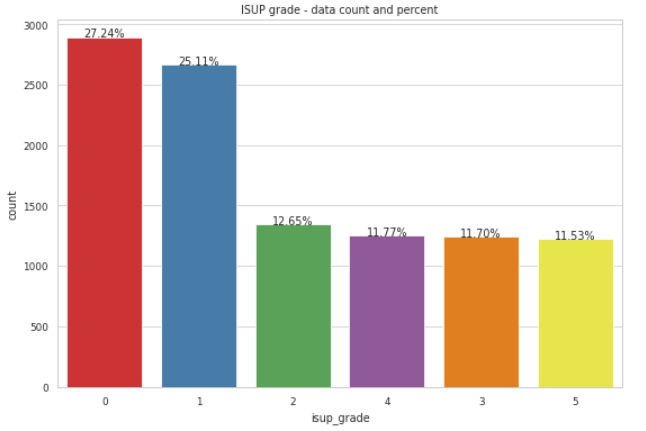

To this:
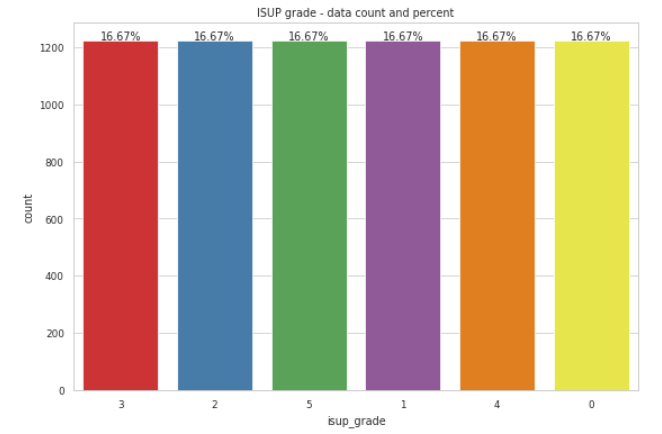

**How to submit**

- This competition requires the internet to be `off` before you can submit to the competition.  For this you will have to create an internet free version of loading fastai to your kernel.  

To make it easier I have provided a convenient `kaggle dataset` with all the files you need to make a successful submission.

- **1** Go to [fastai017_whl](https://www.kaggle.com/avirdee/fastai017-whl) to view the dataset. This dataset provides the 3 files you need to load `fastai2` version 0.0.17, `fastcore` version 0.1.18 and `fastprogress` version 0.2.3 (please upvote if you find this helpful)

- **2** In your kernel click on the `Add data` tab on the right top of the notebook and under the `Search Datasets` bar, enter `fastai017.whl`

- **3** Once the dataset has loaded you will find `fastai017.whl` under the `input` section.

- **5** You can now load all `fastai2` dependencies with the internet off.

# Load the dependancies

## Internet ON

With the internet `on` during the testing phase you would use the standard `pip` methods of loading the `fastai2` dependancies

In [ ]:
!pip install fastai2 --q

## Internet OFF

However with internet `off` as per the competition requirements we need to load the dependancies with the internet `off`.  In this case you will have to load the dependancies like this (by adding [fast017-whl](https://www.kaggle.com/avirdee/fastai017-whl) to your kernel):

In [ ]:
!pip install ../input/fastai017-whl/fastprogress-0.2.3-py3-none-any.whl
!pip install ../input/fastai017-whl/fastcore-0.1.18-py3-none-any.whl
!pip install ../input/fastai017-whl/fastai2-0.0.17-py3-none-any.whl

This will load all the required dependacies

In [ ]:
#Load the dependancies
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

import seaborn as sns
import numpy as np
import pandas as pd
import os
import cv2
import openslide

from sklearn.model_selection import StratifiedShuffleSplit

sns.set(style="whitegrid")
sns.set_context("paper")

With internet off you will also have to load your trained model, for this example I am using `resnet18`.  Once you have add the model to your kernel you have to make a `checkpoints` directory and copy the model to that directory

In [ ]:
Path('/root/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp '../input/resnet18/resnet18.pth' '/root/.cache/torch/checkpoints/resnet18-5c106cde.pth'

In [ ]:
source = Path("../input/prostate-cancer-grade-assessment")
files = os.listdir(source)
print(files)

In [ ]:
train = source/'train_images'
mask = source/'train_label_masks'
train_labels = pd.read_csv(source/'train.csv')

# Balance the Data

The competition requirement is that you have to predict the `isup_grade` for each image in the test set

In [ ]:
train_labels.head()

Plotting the distribution of `isup_grade`

In [ ]:
def plot_count(df, feature, title='', size=2):
    f, ax = plt.subplots(1,1, figsize=(3*size,2*size))
    total = float(len(df))
    sns.countplot(df[feature],order = df[feature].value_counts().index, palette='Set1')
    plt.title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

In [ ]:
plot_count(train_labels, 'isup_grade','ISUP grade - data count and percent', size=3)

This shows us that the distribution of images based on `isup_grade` is unbalanced with the highest number of images being grade `0` and the lowest number of images being grade `5`

Checking to see how many images are within each `isup_grade`

In [ ]:
isup_0 = train_labels[train_labels.isup_grade == 0]
isup_1 = train_labels[train_labels.isup_grade == 1]
isup_2 = train_labels[train_labels.isup_grade == 2]
isup_3 = train_labels[train_labels.isup_grade == 3]
isup_4 = train_labels[train_labels.isup_grade == 4]
isup_5 = train_labels[train_labels.isup_grade == 5]

print(f'isup_0: {len(isup_0)}, isup_1: {len(isup_1)}, isup_2: {len(isup_2)}, isup_3: {len(isup_3)}, isup_4: {len(isup_4)}, isup_5: {len(isup_5)}')

You can quickly balance the data using `sample` so that each class has `1224` images each and then create a balanced dataset

In [ ]:
isup_sam0 = isup_0.sample(n=1224)
isup_sam1 = isup_1.sample(n=1224)
isup_sam2 = isup_2.sample(n=1224)
isup_sam3 = isup_3.sample(n=1224)
isup_sam4 = isup_4.sample(n=1224)

frames = [isup_sam0, isup_sam1, isup_sam2, isup_sam3, isup_sam4, isup_5]
balanced_df = pd. concat(frames)
balanced_df

Looking at the distribution of the balanced dataset we can see that each class is equally represented

In [ ]:
plot_count(balanced_df, 'isup_grade','ISUP grade - data count and percent', size=3)

# Create Train/Test set

In this competition the `test` set is hidden but to get a better idea of how you are doing I am creating another seperate `test` set that we can test on prior to submitting to the competition

Create a copy of the `balanced_df` that we created and split it into a `80/20` split

In [ ]:
df_copy = balanced_df.copy()

# 80/20 split or whatever you choose
train_set = df_copy.sample(frac=0.80, random_state=7)
test_set = df_copy.drop(train_set.index)
print(len(train_set), len(test_set))

So we will have `5875` images in the train set and `1469` images in the test set.

Save `train_set` to `csv` so that we can strattify the training set

In [ ]:
#Save train_set to csv for strattification
train_set.to_csv('split.csv', index=False)

# Stratify the Train Set

For this we use `StratifiedShuffleSplit` from `sklearn` so that we can split the train set into 6 distinct splits and then train on each split

Load the `split.csv` file

In [ ]:
df = pd.read_csv('split.csv')
df.shape[0]

Create a stratified dataframe `strat_df` with `6` splits.  `test_size` here is the % of `strat_df` that will be used for validation.

In [ ]:
sss = StratifiedShuffleSplit(n_splits=6, test_size=0.2, random_state=7)
strat_df = pd.DataFrame()
cols=['isup_grade']

for i, (train_index, test_index) in enumerate(sss.split(df, df.isup_grade)):
    df_split = df.copy()
    df_split['fold'] = i
    df_split.loc[train_index, 'which'] = 'train'
    df_split.loc[test_index, 'which'] = 'valid'
    X_train = df_split.loc[train_index]
    X_valid = df_split.loc[test_index]
    X_train.loc[:, 'which'] = 'train'
    X_valid.loc[:, 'which'] = 'valid'
    
    mult_dis = X_train.loc[X_train.image_id=='isup_grade']
    for _ in range(3): X_train = X_train.append(mult_dis)
    
    strat_df = strat_df.append(X_train).append(X_valid)
    print(i, strat_df.shape, [(X_train[c].sum()/len(X_train), X_train[c].sum()) for c in cols])
strat_df = strat_df.reset_index()

Looking at the created `strat_df`, the `dataframe` now includes the `fold` number and whether it is being used for training or validation

In [ ]:
strat_df.head()

# Viewing the Images

Create a function so that you can easily view the image.  `Fastai2` does not have an in-built method of viewing `.tiff` files.  For viewing the images we use `OpenSlide`

In [ ]:
def view_image(folder, fn):
    filename = f'{folder}/{fn}.tiff'
    file = openslide.OpenSlide(str(filename))
    t = tensor(file.get_thumbnail(size=(255, 255)))
    pil = PILImage.create(t) 
    return pil

Lets view an image with `gleason_score` 3+5 to check it works

In [ ]:
glee_35 = train_labels[train_labels.gleason_score == '3+5']
glee_35[:5]

In [ ]:
view_image(train, '05819281002c55258bb3086cc55e3b48')

# Creating the DataBlock

We have to create a function that can get the images from the folder, open it and change it into a `tensor` as `Fastai2` needs batches to be in the form of tensors or arrays

In [ ]:
def get_i(fn):
    filename = f'{train}/{fn.image_id}.tiff'
    example2 = openslide.OpenSlide(str(filename))
    ee = example2.get_thumbnail(size=(255, 255))
    return tensor(ee)

specify the `blocks`, the `getters` and the `DataBlock`

In [ ]:
blocks = (
          ImageBlock,
          CategoryBlock
          )    
getters = [
           get_i,
           ColReader('isup_grade')
          ]
trends = DataBlock(blocks=blocks,
              splitter=RandomSplitter(),
              getters=getters,
              item_tfms=Resize(256),
              batch_tfms=aug_transforms()
              )

For training with folds we need to specify funtions for training with folds, the dataloader and the learner

In [ ]:
def train_on_folds(bs, size, base_lr, folds):
    learners = []
    all_val_preds = []
    all_val_labels = []
    all_test_preds = []
    
    for fold in range(folds):
        print(f'Processing fold: {fold}....')
        dls = get_dls(bs=bs, size=size, fold=fold, df=strat_df)
        
        learn = get_learner(dls, arch, loss_func, cbs)
        learn = train_learner(learn, base_lr)
        learn.save(f'model_fold_{fold}')
        learners.append(learn)
        learn.recorder.plot_loss()
        
        test_dl = dls.test_dl(train_df)
        test_preds, _, _ = learn.get_preds(dl=test_dl, with_decoded=True)
        val_preds, val_labels = learn.get_preds()
    
        all_val_preds.append(val_preds)
        all_val_labels.append(val_labels)
        all_test_preds.append(test_preds)
    
    plt.show()
    return learners, all_val_preds, all_val_labels, all_test_preds

In [ ]:
set_seed(7)
def get_dls(bs, size, fold, df):
    df_fold = df.copy()
    df_fold = df_fold.loc[df_fold.fold==fold].reset_index()
    
    trends = DataBlock(blocks=blocks,
                       splitter=IndexSplitter(df_fold.loc[df_fold.which=='valid'].index),
                       getters=getters,
                       item_tfms=Resize(256),
                       batch_tfms=aug_transforms(size=size)
                       )
    dls = trends.dataloaders(df_fold, bs=bs)
    assert (len(dls.train_ds) + len(dls.valid_ds)) == len(df_fold)
    return dls

Specify a function for the `learner` and we will use `half precision` hence the `.to_fp16()` to reduce memory and increase training time 

In [ ]:
def get_learner(dls,arch,loss_func, cbs):
    return Learner(dls,arch,loss_func=loss_func,metrics=metrics, cbs=cbs).to_fp16()

The `train_learner` function is fully customiable so you can experiement with any number of `learner` parameters

In [ ]:
def train_learner(learn, base_lr):
    learn.unfreeze()
    learn.fit_one_cycle(2, base_lr)
    
    learn.freeze_to(-2)
    learn.fit_one_cycle(2, base_lr)
    return learn

In [ ]:
dls = get_dls(bs=32, size=128, fold=2, df=strat_df)

Check that `dls.show_batch` works

In [ ]:
dls.show_batch()

In [ ]:
dls.c

We have 6 different classes in the dataset

#### Specify the training parameters

Submissions are scored based on the `quadratic weighted kappa`, which measures the agreement between two outcomes.  To get a good understanding of this metric see this excellent [notebook](https://www.kaggle.com/reighns/understanding-the-quadratic-weighted-kappa) as well as this excellent [notebook](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps)

Cohen's kappa measures the agreement between two raters who each classify N items into C mutually exclusive categories.  A perfect score of 1.0 is granted when both the predictions and actuals are the same.

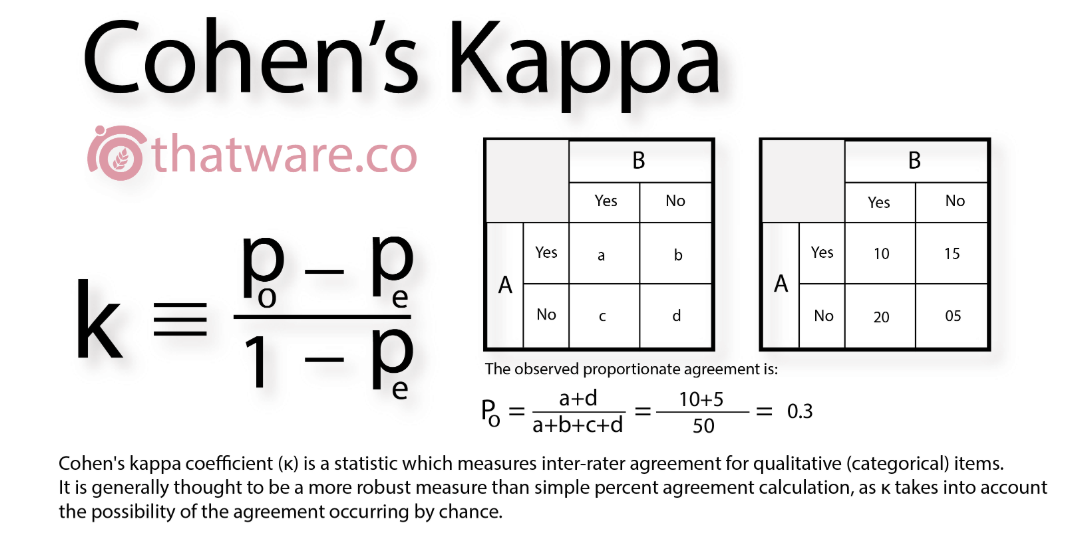

In [ ]:
arch = resnet18(pretrained=True)
loss_func = LabelSmoothingCrossEntropy(eps=0.3, reduction='mean')
cbs = [ShowGraphCallback()]
metrics=[accuracy,CohenKappa(weights='quadratic')]
train_df = pd.read_csv('split.csv')
bs = 32
size = 196

In [ ]:
dls = get_dls(bs=bs, size=size, fold=1, df=strat_df)

In [ ]:
learn = Learner(dls,
                model=arch,
                loss_func=loss_func,
                metrics=metrics,
                cbs=cbs)

Find the best `learning rate`

In [ ]:
learn.lr_find()

In [ ]:
base_lr = 1e-2
learners, all_val_preds, all_val_labels, all_test_preds = train_on_folds(bs, size, base_lr, folds=1)

# Inference on the Test set

We will use the `test_set` that was created

In [ ]:
test_set

Let's look at some of the images in our created `test` set

In [ ]:
learn.load('model_fold_0')

In [ ]:
tst_dl = dls.test_dl(test_set)
tst_dl.show_batch(max_n=9)

Get the predicted classes

In [ ]:
_, _, pred_classes = learn.get_preds(dl=tst_dl, with_decoded=True)

In [ ]:
pred_classes

Let's check out the test results.  For this we create a dataframe of actual and predicted classes

In [ ]:
test_df = test_set.copy()
test_df['isup_grade_pred'] = pred_classes
test_df

Create a `confusion matrix` of the results

In [ ]:
confusion_matrix = pd.crosstab(test_df['isup_grade'], test_df['isup_grade_pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report 
print(classification_report(test_df['isup_grade'], test_df['isup_grade_pred']))

This can further help us tweak the model to get better results

# Submission

In this competition the test set if hidden but we do know that there is a `test_images` folder

In [ ]:
submission_test_path = "../input/prostate-cancer-grade-assessment/test_images/"
sample = '../input/prostate-cancer-grade-assessment/sample_submission.csv'

In [ ]:
sub_df = pd.read_csv(sample)
test_df = pd.read_csv(source/f'test.csv')
if os.path.exists(submission_test_path):
    learn.load('prostate')
    def get_inf(df=test_df):
        filename = f'{submission_test_path}/{df.image_id}.tiff' 
        example2 = openslide.OpenSlide(str(filename))
        ee = example2.get_thumbnail(size=(255, 255))
        return tensor(ee)
    
    blocks = (
          ImageBlock,
          CategoryBlock
          )
    getters = [
           get_inf,
           ColReader('isup_grade')
          ]

    trends = DataBlock(blocks=blocks,
              getters=getters,
              item_tfms=Resize(128)
              )
    
    dls = trends.dataloaders(test_df, bs=32)
    learn = cnn_learner(dls, resnet18)
    
    test_dl = dls.test_dl(test_df)
    _,_,pred_classes = learn.get_preds(dl=test_dl, with_decoded=True)
    
    test_df["isup_grade"] = pred_classes
    sub = test_df[["image_id","isup_grade"]]
    sub.to_csv('submission.csv', index=False)
